# Development of Angular correlation function routine

## Theory

### General Derivation

In this development, we basically follow the arguments of the Simon+2007 paper, and try to repdroduce its results to test consistency.

In general, the correlation function takes two data-sets, which we'll subscript with 1 and 2 throughout. We usually want the "auto-correlation", which means the two sets are equivalent.

Let $n_1(\vec{r})$ and $n_2(\vec{r})$ be two densities fields, as a function of the position $\vec{r}$ in comoving co-ordinates. To obtain the projected density at any angle $\vec{\theta}$, we integrate over all radii, but also filter each slice by a function $q(r)$, which takes into account selection effects (i.e. $q$ is the fraction of galaxies at $r$ that are actually *seen*). Thus:

$$ \hat{n}_i(\vec{\theta}) = \int_0^\infty dr\ q_i(r) n_i(r\vec{\theta},r), $$

and 

$$ \int_0^\infty dr\ q_i(r) = 1, $$

Specifying a different filter function based on the relationship of density *contrast* to density, we have

$$ p_i(r) = \frac{q_i(r) \bar{n}_i(r)}{\int_0^\infty dr\  q_i(r) \bar{n}_i(r)}. $$

This weight specifies not the chance of detecting a given galaxy at radius $r$ (as does $q$), but rather the chance of a galaxy in the sample coming from $r$. That is, it is the radial distribution of galaxies. From here, the formula for the projected correlation simply falls out as

$$ w(\theta) = \int_0^\infty dr_1\ \int_0^\infty dr_2\ p_1(r)1 p_2(r_2) \langle \delta_1(r_1 \theta'_1,r_1) \delta_2(r_2\theta'_2,r_2)\rangle $$

where $\delta$ is the overdensity, and $\theta'_i$ connotes the actual position of the two co-ordinates, which are separated by $\theta$.

The last term here is almost exactly the same as the standard correlation function, and can be transformed to such if we assume that a) the field is isotropic and homogeneous and b) the correlation function doesn't change significantly between $r_1$ and $r_2$ (in the case of an auto-correlation, this is always perfectly true). With these, we get the following general form:

$$ w(\theta) \approx \int_0^\infty dr_1\int_0^\infty dr_2\ p_1(r_1) p_2(r_2) \xi(R,\bar{r}), $$

where 

$$ R \equiv \sqrt{r_1^2 + r_2^2 - 2r_1r_2 \cos \theta}, $$

and 

$$ \bar{r} = (r_1+r_2)/2. $$

### Limber's Approximation

Limber's approximation is this:

$$ w(\theta) = 2\int_0^\infty d\bar{r} p_1(\bar{r}) p_2(\bar{r}) \int_0^{\infty} d\Delta r \xi(R,\bar{r}), $$

where 

$$ R \equiv \sqrt{\bar{r}^2 \theta^2 + \Delta r^2}, $$

and the factor of 2 arises because of the symmetry of the integrand around 0.

The main usefulness of this approxiation is that in the case of a power-law $\xi(r)$, the result is analytic.

However, this breaks down in at least two regimes: 

1. when the distribution of galaxies is thin (approaching a delta function)
2. when $\theta$ is large.

One easy way to see this is to notice that the general result for a correlation function with power-law slope $-\gamma$ is a power-law with slope $1-\gamma$.

However, using the more general equation, with $p_i = \delta(r-r')$, we get the simple result that $w(\theta) = \xi(r'\theta,r')$, i.e. the slope is unchanged.

### Transformation of general equation for numerical use

Though the general equation is valid, it is not necessarily optimal for numerical evaluation, because we can't force $R$ to be logarithmic. However, we can transform the integral to the following:

$$ w(\theta) = \frac{1}{1+\cos \theta} \int_0^\infty d\bar{r} \int\limits_{\bar{r}\sqrt{2(1-\cos \theta)}}^{2\bar{r}} dR\ Q(\bar{r},\Delta) \xi(R,\bar{r}) \frac{R}{\Delta}, $$

where 

$$ \Delta \equiv \frac{1}{\sqrt{2}} \sqrt{\frac{R^2 - 2\bar{r}^2(1-\cos \theta)}{1+\cos \theta}}.$$

and 

$$ Q(\bar{r},\Delta) \equiv p_1(\bar{r}-\Delta)p_2(\bar{r}+\Delta)+p_1(\bar{r}+\Delta)p_2(\bar{r}-\Delta).$$


In the case of Limber's approximation, we also want to do a similar transformation. We have

$$ \frac{dR}{d\Delta r} = \frac{\Delta r}{2R}, $$

so we have

$$ w(\theta) = 2\int_0^\infty d\bar{r}\ p_1(\bar{r}) p_2(\bar{r}) \int_{\bar{r}\theta}^\infty dR\ \frac{2R}{\sqrt{R^2-\bar{r}^2\theta^2}} \xi(R,\bar{r}). $$

### Small-angle approximation

In-built into the Limber approximation is the small-angle approximation, in which $1+\cos \theta \approx 2$. This is accurate to $\sim 10\%$ for angles less than 40 degrees. For their comparison of the general form to the Limber approximation, Simon+2007 employ this approximation to gaurantee fairness, and we'll implement it as well to test. In that case, we have

\begin{align}
 \frac{1}{1+\cos \theta} &\approx 1/2 \\
 \Delta &\approx \frac{1}{2} \sqrt{R^2 - \bar{r}^2\theta^2}\\
 \bar{r}\sqrt{2(1-\cos\theta)} &\approx \bar{r}\theta.
\end{align}

## Implementation

Throughout the following there's a few things to keep in mind. I don't have the luxury of just passing a function which calculates $\xi(R,r)$. I'll have to base it on having array-style functions.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from halomod.halo_exclusion import dblsimps
from scipy.integrate import simps
from mrpy.special import gamma as Gamma

In [115]:
# LIMBER APPROXIMATION

def limber_no_r_dep(theta,xi,p1,p2=None,logx_min=-5,logx_max=5,xnum=100,
                   logu_min=-4,logu_max=2,unum=500):
    # Arrays
    u = np.logspace(logu_min,logu_max,unum) 
    x = np.logspace(logx_min,logx_max,xnum)
    dlnx = np.log(x[1]/x[0])
    dlnu = np.log(u[1]/u[0])
    
    p1 = check_p(p1,x,dlnx)
    
    if p2 is None:
        p2 = p1
    else:
        p2 = check_p(p2,x,dlnx)
    
    R = np.sqrt(np.add.outer(np.outer(theta**2 ,x**2),u**2)).flatten()
    
    integrand = np.einsum("kij,i,j->kij", xi(R).reshape((len(theta),len(x), len(u))), p1(x)*p2(x)* x, u)
    
    return 2*dblsimps(integrand,dlnx,dlnu)

def limber_r_dep(theta,xi,p1,p2=None,logx_min=-5,logx_max=5,xnum=100,
                 logu_min=-4,logu_max=2,unum=500):
    # Arrays
    u = np.logspace(logu_min,logu_max,unum) 
    x = np.logspace(logx_min,logx_max,xnum)
    dlnx = np.log(x[1]/x[0])
    dlnu = np.log(u[1]/u[0])
    
    p1 = check_p(p1,x,dlnx)
    
    if p2 is None:
        p2 = p1
    else:
        p2 = check_p(p2,x,dlnx)
    
    R = np.sqrt(np.add.outer(np.outer(theta**2 ,x**2),u**2))
    xi = xi(np.transpose(R,(0,2,1)),x) #theta, u , x
    print xi.shape
    print (p1(x)*p2(x)* x).shape
    xu_bit = np.outer(u,p1(x)*p2(x)* x)
    
    integrand =  xi*xu_bit
#    np.einsum("kij,i,j->kij", xi , )
    
    return 2*dblsimps(integrand,dlnx,dlnu)
    
def check_p(p,x,dlnx):
    integ = simps(p(x)*x,dx=dlnx)
    if not np.isclose(integ,1.0,rtol=0.01):
        print "WARNING: Filter function p(x) did not integrate to 1 (%s). Tentatively re-normalising."%integ
        return (lambda x: p(x)/integ)
    else:
        return p
    
def limber_analytic_pl(theta,gamma,r0,p1,logx_min=-5,logx_max=5.0,p2=None):
    x = np.logspace(logx_min,logx_max,100)
    dlnx = np.log(x[1]/x[0])
    
    p1 = check_p(p1,x,dlnx)
    
    if p2 is None:
        p2 = p1
    else:
        p2 = check_p(p2,x,dlnx)
        
    pl = 1-gamma
        
    integ = p1(x)*p2(x)*x**pl
    
    Aw = np.sqrt(np.pi)*r0**gamma * Gamma(gamma/2-0.5)/Gamma(gamma/2) * simps(integ*x,dx=dlnx)
    print pl, Aw
    return Aw*theta**pl

-0.77 0.00233979249471
(50, 500, 100)
(100,)
(50, 500, 100)
(100,)
-0.77 0.000945429471088


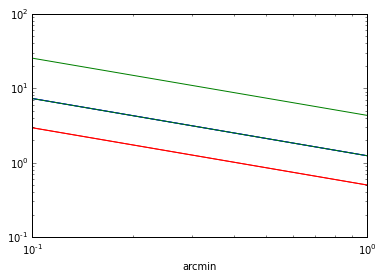

In [118]:
theta = np.logspace(-1,0,50)/3437.75

def pform(xc,sigp):
    return (lambda x: x**2 * np.exp(-0.5*(x-xc)**2/sigp**2))

def pl_xi(gamma,r0):
    return (lambda r: (r/r0)**(-gamma))

def pl_xi_rdep(gamma,r0,rind):
    return (lambda r,x: x**rind * (r/r0)**(-gamma))

plt.plot(3437.75*theta,limber_analytic_pl(theta,1.77,5.4,pform(500,500*0.15),logx_min=2,logx_max=3),color="b")
plt.plot(3437.75*theta,limber_no_r_dep(theta,pl_xi(1.77,5.4),pform(500,500*0.15),logx_min=2,logx_max=3,logu_max=5),color="b")
plt.plot(3437.75*theta,limber_r_dep(theta,pl_xi_rdep(1.77,5.4,0.0),pform(500,500*0.15),logx_min=2,logx_max=3,logu_max=5),color="g")
plt.plot(3437.75*theta,limber_r_dep(theta,pl_xi_rdep(1.77,5.4,0.2),pform(500,500*0.15),logx_min=2,logx_max=3,logu_max=5),color="g")

plt.plot(3437.75*theta,limber_analytic_pl(theta,1.77,5.4,pform(500,500*0.37),logx_min=2,logx_max=3),color="r")
plt.plot(3437.75*theta,limber_no_r_dep(theta,pl_xi(1.77,5.4),pform(500,500*0.37),logx_min=2,logx_max=3,logu_max=5),color="r")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("arcmin")

In [94]:
def general_no_r_dep(theta,xi,p1,p2=None,logx_min=-5,logx_max=5,xnum=100,
                     rmin=0.01,rmax = 1e4,
                     f=0.001,Rnum=500,dR_min=1e-4):
    # Arrays
    x = np.logspace(logx_min,logx_max,xnum)
    dlnx = np.log(x[1]/x[0])
    
    p1 = check_p(p1,x,dlnx)
    if p2 is None:
        p2 = p1
    else:
        p2 = check_p(p2,x,dlnx)
    
    Rmin = np.outer(x,np.sqrt(2*(1-np.cos(theta))))   # (x*theta array)
    
    # Assuming a roughly power-law slope, get approximately 1-f of the integral
    # below (1-f)**(1./(1-slope)) times the minimum.
    slope = -np.log(xi(rmax)/xi(rmin))/np.log(rmax/rmin)
    a = f**(1./(1-slope))
    print slope, a
    
    # Problem witht he following is that Rmax may be greater than 2*x, which is impossible.
    #Rmax = Rmin * a
    R = np.logspace(0,np.log10(a),Rnum)
    dlnR = np.log(R[1])
    
    R = np.outer(R,(Rmin+dR_min)).reshape((Rnum,len(x),len(theta))) #(Rnum,x,theta) array.
    x2theta = np.outer(2*x**2,(1-np.cos(theta))) # (x,theta) array
    x2theta = np.clip(R**2 - x2theta,0,np.inf)
    
    Delta = np.transpose(np.sqrt(x2theta/(2*(1+np.cos(theta)))),(2,0,1)) #(theta,Rnum,x) array
    
    Q = p1(x-Delta)*p2(x+Delta) + p1(x+Delta)*p2(x-Delta) #(theta,Rnum,x array)
    integrand = Q*xi(R.flatten()).reshape((len(theta),Rnum,len(x))) * np.transpose(R**2,(2,0,1))/Delta * x
    
    #print integrand, dlnR, dlnx
    return dblsimps(integrand,dlnR, dlnx)

In [95]:
theta = np.logspace(-2,-1,5)
a = general_no_r_dep(theta,pl_xi(1.77,5.4),pform(500,500*0.15),xnum=10,Rnum=8)
print a

1.77 7872.34096884
[  3.42481852e+08   4.08858649e+05   6.00569789e+04   1.05714466e+03
   5.54148752e-02]


In [92]:
a

array([  3.42481852e+08,   4.08858649e+05,   6.00569789e+04,
         1.05714466e+03,   5.54148752e-02])

-0.77 0.00233979249471
1.77 7872.34096884
-0.77 0.000945429471088


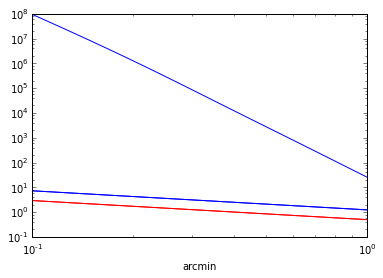

In [96]:
theta = np.logspace(-1,0,50)/3437.75

def pform(xc,sigp):
    return (lambda x: x**2 * np.exp(-0.5*(x-xc)**2/sigp**2))

def pl_xi(gamma,r0):
    return (lambda r: (r/r0)**(-gamma))

plt.plot(3437.75*theta,limber_analytic_pl(theta,1.77,5.4,pform(500,500*0.15),logx_min=2,logx_max=3),color="b")
plt.plot(3437.75*theta,limber_no_r_dep(theta,pl_xi(1.77,5.4),pform(500,500*0.15),logx_min=2,logx_max=3,logu_max=5),color="b")
plt.plot(3437.75*theta,general_no_r_dep(theta,pl_xi(1.77,5.4),pform(500,500*0.15)),color="b")

plt.plot(3437.75*theta,limber_analytic_pl(theta,1.77,5.4,pform(500,500*0.37),logx_min=2,logx_max=3),color="r")
plt.plot(3437.75*theta,limber_no_r_dep(theta,pl_xi(1.77,5.4),pform(500,500*0.37),logx_min=2,logx_max=3,logu_max=5),color="r")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("arcmin")

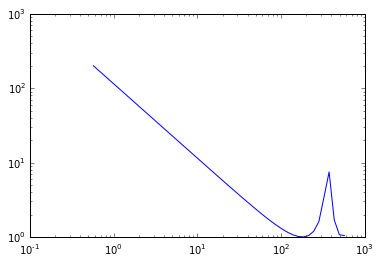

In [38]:
theta = np.logspace(-2,1,50)
plt.plot(theta*180.0/np.pi,2./np.sqrt(2*(1-np.cos(theta))))
plt.xscale('log')
plt.yscale('log')